In [29]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
seed_everything(SEED)

In [2]:
ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is 8871-4212

 Directory of C:\Users\LENOVO

22-08-2024  00:39    <DIR>          .
22-08-2024  00:39    <DIR>          ..
18-08-2024  16:23       336,441,344 .chembl_ws_client__0.10.8
21-08-2024  19:25       188,035,072 .chembl_ws_client__0.10.9
09-06-2023  14:24    <DIR>          .conda
25-04-2022  20:59                38 .condarc
09-01-2021  15:14    <DIR>          .config
31-12-2022  12:58               204 .gitconfig
08-12-2021  02:36    <DIR>          .idlerc
20-08-2024  20:33    <DIR>          .ipynb_checkpoints
26-07-2021  13:28    <DIR>          .ipython
25-03-2023  01:21            20,051 .iqmol.log
15-08-2021  22:28    <DIR>          .jupyter
05-08-2022  23:27    <DIR>          .keras
26-07-2021  13:28    <DIR>          .matplotlib
08-12-2021  02:36    <DIR>          .mgltools
24-04-2023  13:24    <DIR>          .ms-ad
10-01-2021  21:23                 0 .node_repl_history
11-01-2021  21:18    <DIR>          .node-red
01

In [3]:
# Read data from previous talktorials
chembl_df = pd.read_csv("EGFR_compounds_lipinski.csv",
    index_col=0,
)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()
# NBVAL_CHECK_OUTPUT


19-06-2022  19:38            12,374 Untitled16.ipynb
21-05-2022  16:09            43,475 Untitled17.ipynb
22-05-2022  20:57            45,108 Untitled18.ipynb
26-05-2022  09:21           238,764 Untitled19.ipynb
19-04-2022  14:52             5,822 Untitled2.ipynb
26-05-2022  09:02            53,353 Untitled20.ipynb
26-05-2022  09:37            47,768 Untitled21.ipynb
26-05-2022  09:38            47,555 Untitled22.ipynb
26-05-2022  09:40            48,311 Untitled23.ipynb
27-05-2022  07:24           646,531 Untitled24.ipynb
05-06-2022  09:19                72 Untitled25.ipynb
27-05-2022  07:41                72 Untitled26.ipynb
27-05-2022  15:55               631 Untitled27.ipynb
27-05-2022  18:17             8,558 Untitled28.ipynb
27-05-2022  19:51             2,785 Untitled29.ipynb
21-04-2022  22:18             8,964 Untitled3.ipynb
28-05-2022  08:59             4,519 Untitled30.ipynb
28-05-2022  09:42             1,865 Untitled31.ipynb
28-05-2022  20:57             6,399 Untitled32.

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True
5,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True


In [4]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
3,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
5,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910


In [5]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 3359
Number of inactive compounds: 2244


In [7]:
chembl_df.head(15)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0
3,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0
5,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0
6,CHEMBL176582,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000,1.0
7,CHEMBL29197,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,10.602060,1.0
8,CHEMBL174426,Cn1cnc2cc3c(Nc4cccc(Br)c4)ncnc3cc21,10.602060,1.0
9,CHEMBL5288888,C=CC(=O)N1CCC(Oc2cc3c(Nc4cccc(Cl)c4F)ncnc3cc2O...,10.568636,1.0
10,CHEMBL1243316,C#CCNC/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N...,10.522879,1.0


In [13]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [14]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [15]:
compound_df = chembl_df.copy()

In [11]:
compound_df

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0
3,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0
5,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0
...,...,...,...,...
7068,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0
7069,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0
7070,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0
7072,CHEMBL45068,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,1.602060,0.0


In [16]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [18]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [19]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [20]:
%whos DataFrame

Variable      Type         Data/Info
------------------------------------
chembl_df     DataFrame         molecule_chembl_id  <...>\n[5603 rows x 4 columns]
compound_df   DataFrame         molecule_chembl_id  <...>\n[5603 rows x 5 columns]


In [22]:
from sklearn.model_selection import train_test_split

In [25]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=22)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 4482
Test data size: 1121


In [30]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [33]:
%whos list

Variable               Type    Data/Info
----------------------------------------
fingerprint_to_model   list    n=5603
label_to_model         list    n=5603
splits                 list    n=4
static_test_x          list    n=1121
static_test_y          list    n=1121
static_train_x         list    n=4482
static_train_y         list    n=4482


In [34]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.88
Specificity: 0.72
AUC: 0.88


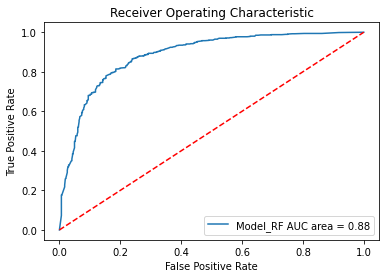

In [35]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [36]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.88
Specificity: 0.72
AUC: 0.88


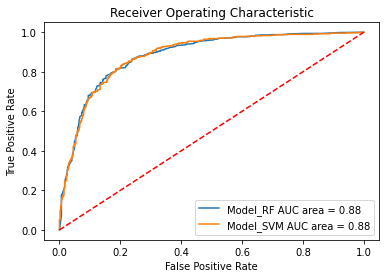

In [37]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [48]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.84
Specificity: 0.70
AUC: 0.85


In [46]:
del model_ANN

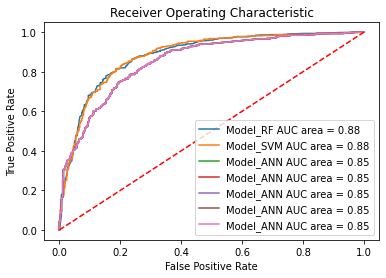

In [49]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

In [50]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [51]:
N_FOLDS = 3

In [52]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.82 	and std : 0.00 
Mean sensitivity: 0.88 	and std : 0.01 
Mean specificity: 0.73 	and std : 0.01 
Mean AUC: 0.88 	and std : 0.00 
Time taken : 1.98s


Model_SVM
Mean accuracy: 0.83 	and std : 0.00 
Mean sensitivity: 0.91 	and std : 0.00 
Mean specificity: 0.71 	and std : 0.00 
Mean AUC: 0.88 	and std : 0.01 
Time taken : 21.43s


Model_ANN
Mean accuracy: 0.79 	and std : 0.00 
Mean sensitivity: 0.86 	and std : 0.01 
Mean specificity: 0.70 	and std : 0.01 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 6.31s


Model_ANN
Mean accuracy: 0.79 	and std : 0.00 
Mean sensitivity: 0.86 	and std : 0.01 
Mean specificity: 0.70 	and std : 0.01 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 6.24s


Model_ANN
Mean accuracy: 0.79 	and std : 0.00 
Mean sensitivity: 0.86 	and std : 0.01 
Mean specificity: 0.70 	and std : 0.01 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 6.53s


Model_ANN
Mean accuracy: 0.79 	and std : 0.00 
Mean sensitivity: 0.86 	and std : 0.01 
Mean specifi

In [53]:
# Reset data frame
compound_df = chembl_df.copy()

In [54]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [55]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.85 	and std : 0.00 
Mean sensitivity: 0.90 	and std : 0.00 
Mean specificity: 0.78 	and std : 0.01 
Mean AUC: 0.91 	and std : 0.00 
Time taken : 7.12s


Model_ANN
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.85 	and std : 0.02 
Mean specificity: 0.73 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.00 
Time taken : 26.43s


Model_ANN
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.85 	and std : 0.02 
Mean specificity: 0.73 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.00 
Time taken : 26.52s


Model_ANN
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.85 	and std : 0.02 
Mean specificity: 0.73 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.00 
Time taken : 24.72s


Model_ANN
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.85 	and std : 0.02 
Mean specificity: 0.73 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.00 
Time taken : 26.47s


Model_ANN
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.85 	and std : 0.02 
Mean spec